In [1]:
%matplotlib inline
import math
import string
import random
import random
import bitarray
import mmh3
import matplotlib.pyplot as plt

Probabilistic data structures let us save RAM by sacrificing accuracy. Different types of probabilistic data structures do this differently, and therefore they are more useful for different applications. 

## Morris counter

A Morris counter is useful when we need to count large numbers but precission is not that important. This is how it works:

- set the counter at i = 0
- when querying the counter, return 2 ^ i, and increment i with probability 1 / 2 ^ i

So, for instance, the first time we query the counter we obtain the value 1. Next time we will get the value 2. Then we will get the value 2 or 4 with 0.5 probability each, etc. The more we count, the more inaccurate the value is. Therefore, this method is useful when we are interested to know orders of magniture.

If we only use one byte to store the value of i (so that the maximum value of i is 256), we can count up to 2 ^ 256, which would require many more bytes.

In the plot below, the continuous line represents the increment of a normal integer, which requires multiple bytes. The dotted lines represent the increment of three different 1 byte Morris counter. We compare to three runs of the Morris counter due to the random nature of the algorithm. 

In [2]:
def morris_counter(n):
    it = 0
    i = 0
    while it < n:
        yield 2 ** i
        
        if random.random() <= 1 / (2 ** i):
            i = i + 1
            
        it = it + 1

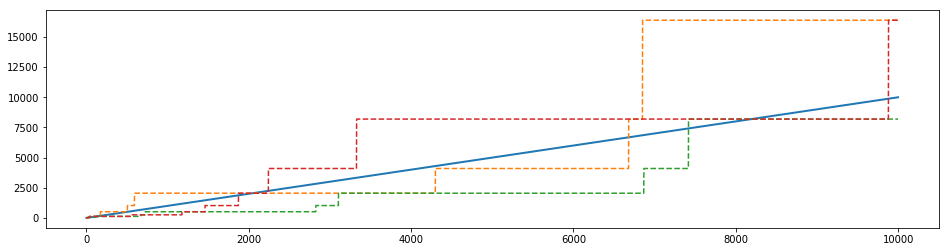

In [3]:
fig, ax = plt.subplots()
ax.plot(range(10000), range(10000), lw = 2)
ax.plot(range(10000), list(morris_counter(10000)), '--')
ax.plot(range(10000), list(morris_counter(10000)), '--')
ax.plot(range(10000), list(morris_counter(10000)), '--')
fig.set_figwidth(16)

## Bloom filters

Bloom filters are data structures that were created to answer the quesition of whether we have seen an item before. An item is represented by a set of hash codes. The status of hash codes is stored as a list of booleans. Initially, all values are false. When we insert an item, the index of all its derived hash codes is set to True. To test whether an object was already inserted, we just check the value of its corresponding hash indexes. 

There are no false negatives (if the Bloom filter says that we didn't see an item, we certainly didn't) and there is a 0.5% probability of false positives (if we identify an item as already in the data structure, there is a 0.5% probability that this is due to hash collisions.)

The length of the bool array (the number of bits) and the number of hash values to represent each item depends on the required capacity and error rate. 

In this example we are using bits to represent the bool array instead of booleans, because booleans actually take 4 bits.

In [4]:
class BloomFilter(object):
    def __init__(self, capacity, error = 0.005):
        '''
        Initialise a Bloom filter with given capacity and a false positive rate
        '''
        self.capacity = capacity
        self.error = error
        self.num_bits = int(-capacity * math.log(error) / math.log(2)**2) + 1
        self.num_hashes = int(self.num_bits * math.log(2) / float(capacity)) + 1
        self.data = bitarray.bitarray(self.num_bits)
        
    def _indexes(self, key):
        h1, h2 = mmh3.hash64(key)
        for i in range(self.num_hashes):
            yield (h1 + i * h2) % self.num_bits
            
    def add(self, key):
        for index in self._indexes(key):
            self.data[index] = True
            
    def __contains__(self, key):
        return all(self.data[index] for index in self._indexes(key))
    
    def __len__(self):
        num_bits_on = self.data.count(True)
        return -1.0 * self.num_bits * \
                      math.log(1.0 - num_bits_on / float(self.num_bits)) / \
                      float(self.num_hashes)
            
    @staticmethod
    def untion(bloom_a, bloom_b):
        assert bloom_a.capacity == bloom_b.capacity
        assert bloom_a.error == bloom_b.error
        
        bloom_union = BloomFilter(bloom_a.capacity, bloom_a.error)
        bloom_union.data = bloom_a.data | bloom_b.data
        
        return bloom_union

Let's create a set of 1000 unique random strings

In [5]:
def create_words(n):
    words = []
    while len(words) < n:
        word = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(10))
        if word not in words:
            words.append(word)
    return words

And now let's plot the ratio of false positives as we add more words to a BloomFilter, especially as we go beyond its capacity. We will create a BloomFilter with a capacity of 500. We will insert 700 words and use th 300 remaining ones as a test set to calculate the false positives rate. 

In [6]:
words = create_words(1000)
bf = BloomFilter(500)
fp = []
for i in range(700):
    bf.add(words[i])
    falses = 0
    for j in range(700, 1000):
        if words[j] in bf:
            falses = falses + 1
    fp.append(falses/300 * 100)

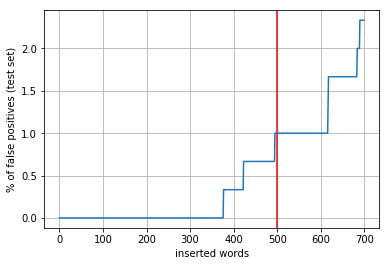

In [7]:
fig, ax = plt.subplots()
ax.set_xlabel('inserted words')
ax.set_ylabel('% of false positives (test set)')
ax.axvline(x = 500, color = 'r')
ax.grid(True)
plt.plot(fp)

## LogLog counters

LogLog counters, as it was the case of the Morris counter, are designed to count items. They are based on using the hash code of the input element as a replacement of the random sequence. The counter is only incremented if the number of trailing zeros of the input's hash is higher than the current count.

In [8]:
def trailing_zeros(number):
    '''
    Returns the index of the first bit set to 1 from the right side of a 32 bit integer
    '''
    if not number:
        return 32
    index = 0
    while (number >> index) & 1 == 0:
        index += 1
    return index

In [9]:
class LogLogRegister(object):
    counter = 0
    
    def add(self, item):
        item_hash = mmh3.hash(str(item))
        return self._add(item_hash)
    

    def _add(self, item_hash):
        bit_index = trailing_zeros(item_hash)
        if bit_index > self.counter:
            self.counter = bit_index
            
    def __len__(self):
        return 2 ** self.counter

In [10]:
def count_log_log(loglog, items):
    for item in items:
        loglog.add(item)
        
        yield(len(loglog))

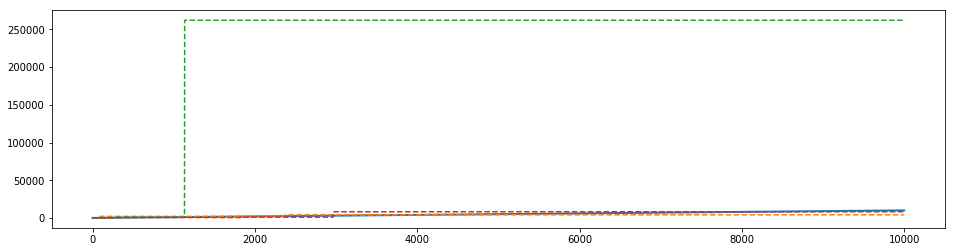

In [11]:
fig, ax = plt.subplots()
ax.plot(range(10000), range(10000), lw = 2)
ax.plot(range(10000), list(count_log_log(LogLogRegister(), create_words(10000))), '--')
ax.plot(range(10000), list(count_log_log(LogLogRegister(), create_words(10000))), '--')
ax.plot(range(10000), list(count_log_log(LogLogRegister(), create_words(10000))), '--')
fig.set_figwidth(16)

The problem with his method is that we may be 'unlucky' and get an input item with a very high number of trailing zeros at the beginning of the sequence. This is solved by combining multiple LogLog counters. 

The following implementation uses the first 4 bits to indicate which one of the out of 16 LogLog counters we are using to add the item. When getting the count, we use an average of all the LogLog counters. The alpha parameter acts as a normalisation parameter.

In [12]:
class LL(LogLogRegister):
    def __init__(self, p):
        self.p = p
        self.num_registers = 2 ** p
        self.registers = [LogLogRegister() for i in range(int(2 ** p))]
        self.alpha = 0.7213 / (1.0 + 1.079 / self.num_registers)
        
    def add(self, item):
        item_hash = mmh3.hash(str(item))
        register_index = item_hash & (self.num_registers - 1)
        register_hash = item_hash >> self.p
        self.registers[register_index]._add(register_hash)
        
    def __len__(self):
        register_sum = sum(h.counter for h in self.registers)
        return int(self.num_registers * self.alpha * 2 ** (float(register_sum) / self.num_registers))

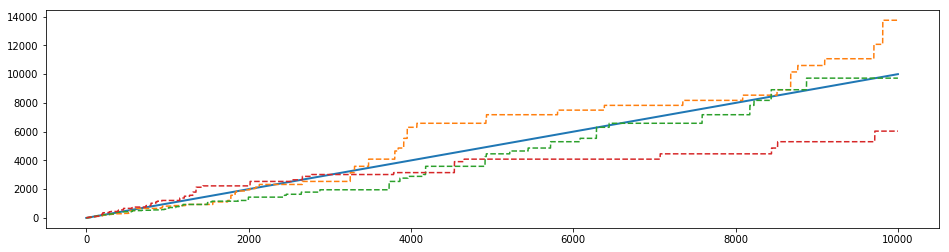

In [13]:
fig, ax = plt.subplots()
ax.plot(range(10000), range(10000), lw = 2)
ax.plot(range(10000), list(count_log_log(LL(4), create_words(10000))), '--')
ax.plot(range(10000), list(count_log_log(LL(4), create_words(10000))), '--')
ax.plot(range(10000), list(count_log_log(LL(4), create_words(10000))), '--')
fig.set_figwidth(16)

HyperLogLog is another example of LogLog counter in which we only change the averaging method using a spherical averaging scheme that also has special considerations for different edge cases:

In [14]:
class HyperLogLog(LL):
    def __len__(self):
        indicator = sum(2 ** - m.counter for m in self.registers)
        E = self.alpha * (self.num_registers ** 2) / float(indicator)
        
        if E <= 5.0 / 2.0 * self.num_registers:
            V = sum(1 for m in self.registers if m.counter == 0)
            if V != 0:
                Estar = self.num_registers * math.log(self.num_registers / (1.0 * V), 2)
            else:
                Esgar = E
        else:
            if E <= 2 ** 32 / 30.0:
                Estar = E
            else:
                Estar = -2 ** 32 * math.log(1 - E / 2 ** 32, 2)
        
        return (int(Estar))

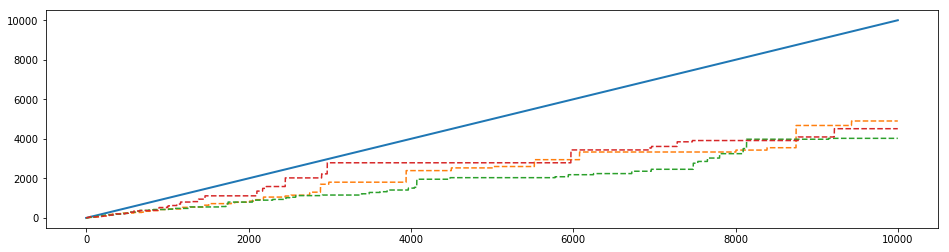

In [15]:
fig, ax = plt.subplots()
ax.plot(range(10000), range(10000), lw = 2)
ax.plot(range(10000), list(count_log_log(HyperLogLog(4), create_words(10000))), '--')
ax.plot(range(10000), list(count_log_log(HyperLogLog(4), create_words(10000))), '--')
ax.plot(range(10000), list(count_log_log(HyperLogLog(4), create_words(10000))), '--')
fig.set_figwidth(16)